# Clustering and PCA

### Mushroom Dataset

Podeis obtener el conjunto de datos en el siguiente enlace:

[Mushroom Dataset](https://www.kaggle.com/uciml/mushroom-classification)

Como podréis comprobar, hay muchas variables, todas ellas categóricas, por lo que exploraciones con scatterplot no nos serán útiles como en otros casos.

La variable a predecir ``class`` es binaria.


In [1]:
# Carga de librerías, las que hemos considerado básicas, añadid lo que queráis :)

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

### Leer conjunto de datos y primer vistazo

In [2]:
# Leer el csv y sacar por pantalla las cinco primeras filas.
# Leer el archivo CSV
df = pd.read_csv('mushrooms.csv')

# Primeras filas
print(df.head())

# Dimensiones del dataset
print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1       

### Exploración de datos

In [3]:
# Descripción del conjunto de datos, estándard.
# Para variables numéricas y categóricas:
print(df.describe(include='all'))

       class cap-shape cap-surface cap-color bruises  odor gill-attachment  \
count   8124      8124        8124      8124    8124  8124            8124   
unique     2         6           4        10       2     9               2   
top        e         x           y         n       f     n               f   
freq    4208      3656        3244      2284    4748  3528            7914   

       gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
count          8124      8124       8124  ...                     8124   
unique            2         2         12  ...                        4   
top               c         b          b  ...                        s   
freq           6812      5612       1728  ...                     4936   

       stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
count                    8124                   8124      8124       8124   
unique                      9                      9         1          4   
top    

In [4]:
# Información sobre el tipo de datos de cada feature.
# Esto nos permite ver si hay columnas que no son categóricas, si hay valores nulos y el tipo de dato de cada columna.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

### 📝 Descripción del conjunto de datos

Este conjunto de datos contiene **8124 instancias** de diferentes tipos de hongos, clasificados como:

- `e`: comestibles (*edible*)
- `p`: venenosos (*poisonous*)

Cada instancia representa un hongo y tiene **22 atributos categóricos**, como:

- Forma, superficie y color del sombrero (`cap-shape`, `cap-surface`, `cap-color`)
- Presencia de magulladuras (`bruises`)
- Olor (`odor`)
- Características de las láminas (`gill-attachment`, `gill-spacing`, `gill-size`, `gill-color`)
- Forma y raíz del tallo (`stalk-shape`, `stalk-root`)
- Colores y superficies del tallo (`stalk-color-above-ring`, `stalk-surface-below-ring`, etc.)
- Tipo y número de anillo (`ring-type`, `ring-number`)
- Color de impresión de esporas (`spore-print-color`)
- Hábitat y población (`habitat`, `population`)

> Todas las variables son categóricas.

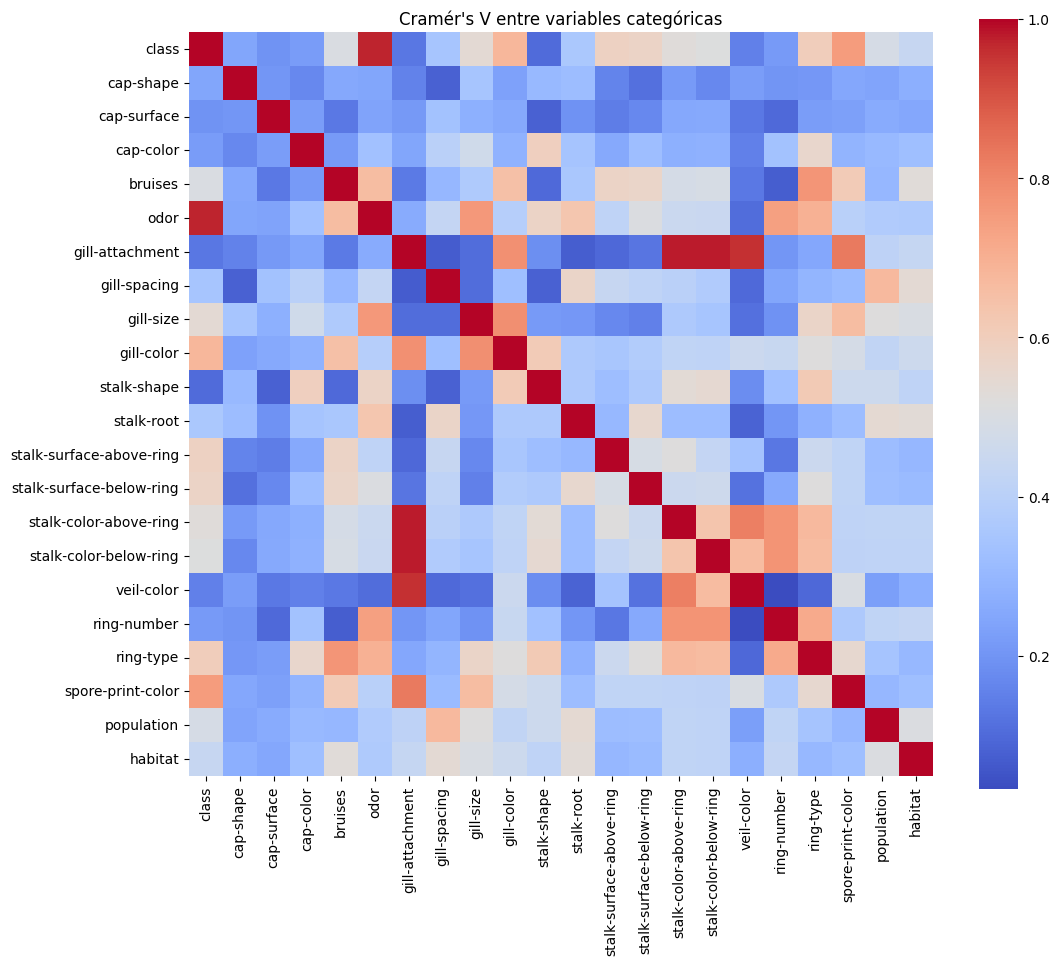

In [26]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

cat_cols = df.columns
cramer_matrix = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramer_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

plt.figure(figsize=(12, 10))
sns.heatmap(cramer_matrix, annot=False, cmap="coolwarm", square=True)
plt.title("Cramér's V entre variables categóricas")
plt.show()

## 🔗 Análisis de asociación entre variables categóricas — Cramér's V

Se utilizó el coeficiente **Cramér’s V** para medir la **fuerza de asociación** entre todas las variables categóricas del dataset. Este coeficiente es especialmente útil en datasets como el de setas, donde todas las variables son categóricas.

### 🧠 ¿Qué es Cramér's V?

- Es una métrica basada en la prueba de chi-cuadrado.
- Oscila entre `0` y `1`:
  - `0`: sin asociación entre variables
  - `1`: asociación perfecta
- Es simétrica y no depende del tamaño de las tablas.

### 📊 Interpretación del heatmap:

- Cada celda representa la **fuerza de relación entre dos variables**.
- Se observan asociaciones altas (colores rojizos) entre:
  - `gill-size` y `gill-spacing`
  - `odor` y `class` (lo cual es coherente: el olor puede indicar toxicidad)
  - `ring-type` con `ring-number`, y `stalk-color-above-ring` con `stalk-color-below-ring`
- La diagonal está en `1.0` porque cada variable se asocia perfectamente consigo misma.

### 🧪 Conclusión:

Este análisis permite identificar variables redundantes o muy correlacionadas, lo cual puede ser útil para:
- Reducir dimensionalidad
- Detectar multicolinealidad
- Priorizar variables con mayor relación con la clase objetivo (`class`)


#### Calcular el número de nulos de cada feature

In [5]:
# Igual que otras veces, una linea, contar los nulos por variable.
# Contar valores nulos por columna
print(df.isnull().sum())

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64


#### Buscar valores extraños. Para ello, ver los valores únicos en cada feature

In [6]:
# Obtener un nuevo dataframe de dos columnas donde en la primera estén las features (features) y en la otra los valores únicos
# asociados (n_values).
# Buscar valores extraños: ver los valores únicos en cada feature.
# Creamos un DataFrame con dos columnas: 'feature' y 'n_values', donde 'n_values' es la lista de valores únicos de cada columna.

features = []
n_values = []

for col in df.columns:
    features.append(col)
    n_values.append(df[col].unique())

valores_unicos_df = pd.DataFrame({'feature': features, 'n_values': n_values})

print(valores_unicos_df)

                     feature                              n_values
0                      class                                [p, e]
1                  cap-shape                    [x, b, s, f, k, c]
2                cap-surface                          [s, y, f, g]
3                  cap-color        [n, y, w, g, e, p, b, u, c, r]
4                    bruises                                [t, f]
5                       odor           [p, a, l, n, f, c, y, s, m]
6            gill-attachment                                [f, a]
7               gill-spacing                                [c, w]
8                  gill-size                                [n, b]
9                 gill-color  [k, n, g, p, w, h, u, e, b, r, y, o]
10               stalk-shape                                [e, t]
11                stalk-root                       [e, c, b, r, ?]
12  stalk-surface-above-ring                          [s, f, k, y]
13  stalk-surface-below-ring                          [s, f, y

### Resumen valores extraños
La columna `stalk-root` tiene valores faltantes que fueron representados originalmente con `'?'

#### Tratar aquellos valores que entendamos que sean nulos


In [7]:
# Imputaciones. Podéis quitar esos puntos (fila entera), imputar con la moda o dejar ese valor como una posibilidad más.
# En el dataset de hongos, los valores nulos suelen estar representados por el carácter '?' en la columna 'stalk-root'.
# Podemos imputar esos valores con la moda (el valor más frecuente) de la columna para no perder información.

# Contar cuántos valores '?' hay en cada columna
print("Valores '?' por columna:\n", (df == '?').sum())

# Imputar la columna 'stalk-root' con la moda si tiene valores '?'
if (df['stalk-root'] == '?').any():
    moda = df['stalk-root'].mode()[0]
    df['stalk-root'] = df['stalk-root'].replace('?', moda)
    print(f"Valores '?' en 'stalk-root' reemplazados por la moda: {moda}")

# Alternativamente, si prefieres eliminar las filas con '?', puedes usar:
# df = df[df['stalk-root'] != '?']

# Comentario:
# - Imputar con la moda es útil cuando hay pocos valores nulos y no queremos perder datos.
# - Eliminar filas es útil si hay muy pocos casos y queremos máxima limpieza.

Valores '?' por columna:
 class                          0
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64
Valores '?' en 'stalk-root' reemplazados por la moda: b


#### Mirad cuántos valores hay en cada feature, ¿Todas las features aportan información? Si alguna no aporta información, eliminadla

In [8]:
# Revisamos cuántos valores únicos tiene cada columna
for col in df.columns:
    print(f"{col}: {df[col].nunique()} valores únicos")

# Identificamos columnas con un solo valor único (no aportan información)
cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]
print("Columnas a eliminar por ser constantes:", cols_to_drop)

# Eliminamos esas columnas del DataFrame
df = df.drop(columns=cols_to_drop)

# Explicación:
# - Revisamos la cantidad de valores únicos por columna para detectar columnas constantes.
# - Eliminamos las columnas que no aportan información al análisis o al modelo.

class: 2 valores únicos
cap-shape: 6 valores únicos
cap-surface: 4 valores únicos
cap-color: 10 valores únicos
bruises: 2 valores únicos
odor: 9 valores únicos
gill-attachment: 2 valores únicos
gill-spacing: 2 valores únicos
gill-size: 2 valores únicos
gill-color: 12 valores únicos
stalk-shape: 2 valores únicos
stalk-root: 4 valores únicos
stalk-surface-above-ring: 4 valores únicos
stalk-surface-below-ring: 4 valores únicos
stalk-color-above-ring: 9 valores únicos
stalk-color-below-ring: 9 valores únicos
veil-type: 1 valores únicos
veil-color: 4 valores únicos
ring-number: 3 valores únicos
ring-type: 5 valores únicos
spore-print-color: 9 valores únicos
population: 6 valores únicos
habitat: 7 valores únicos
Columnas a eliminar por ser constantes: ['veil-type']


#### Separar entre variables predictoras y variables a predecir

In [9]:
# --- Separar entre variables predictoras y variables a predecir ---

# La variable objetivo es 'class', que indica si el hongo es comestible ('e') o venenoso ('p').
# Separamos la variable objetivo (y) y las variables predictoras (X).
y = df['class']  # Variable a predecir
X = df.drop(columns=['class'])  # Variables predictoras

#### Codificar correctamente las variables categóricas a numéricas

In [20]:
# One Hot Encoder (una linea).
# Todas las variables son categóricas, así que usamos OneHotEncoder para convertirlas a variables numéricas.
# Usamos pandas.get_dummies porque es sencillo y rápido para este caso.
X_encoded = pd.get_dummies(X)
print("Nueva forma de X:", X_encoded.shape)
# Explicación:
# - get_dummies crea una columna binaria para cada valor posible de cada variable categórica.
# - Esto es necesario porque los modelos de machine learning de sklearn solo aceptan variables numéricas.

Nueva forma de X: (8124, 115)


In [22]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Columns: 115 entries, cap-shape_b to habitat_w
dtypes: bool(115)
memory usage: 912.5 KB


### 🧠 One-Hot Encoding

Se aplicó One-Hot Encoding a las variables categóricas para convertirlas a formato numérico binario.

- El número original de columnas era: 22
- Tras codificar, el número total de columnas es: **115**
- Esto se debe a que cada categoría única genera una nueva columna binaria.



#### Train test split

In [11]:
# --- Train test split ---

# Dividimos el dataset en entrenamiento y test (67% train, 33% test).
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.33, random_state=42)

# Explicación:
# - Esto nos permite entrenar el modelo con una parte de los datos y evaluar su rendimiento con datos que no ha visto.

## PCA

Es un conjunto de datos del que aún no hemos visto nada (no tenemos graficas) así que vamos a hacer algunas. Tenemos el problema de que son muchas variables, **PCA al rescate**: le pedimos que nos de dos dimensiones y las pintamos, sabemos que serán **aquellas que retengan más información**.

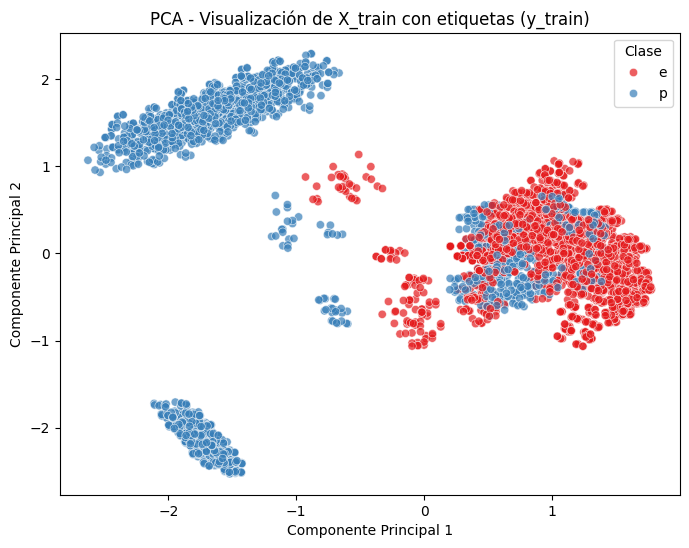

In [12]:
from sklearn.preprocessing import OneHotEncoder

# Codificar todo el X primero
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X)

# Luego split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.33, random_state=42)

# Y ahora sí:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Crear el gráfico scatter con las etiquetas de entrenamiento
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette="Set1", alpha=0.7)

plt.title("PCA - Visualización de X_train con etiquetas (y_train)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Clase")
plt.show()

Parece que está bastante separadito, parece que a ojo mucho se puede ver :)

Igualmente, vamos a entrenar un clasificador a ver qué tal lo hace antes de editar más

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predecir sobre el test set
y_pred = clf.predict(X_test)

# Calcular precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión en test: {accuracy:.4f}")

Precisión en test: 1.0000


Es un conjunto sencillo y Random Forest es muy bueno en su trabajo, Igualmente, vamos a ver qué tamaño tenemos de dataset:


In [14]:
X_train.shape

(5443, 115)

¿Muchas features no? Vamos a reducir las usando PCA.

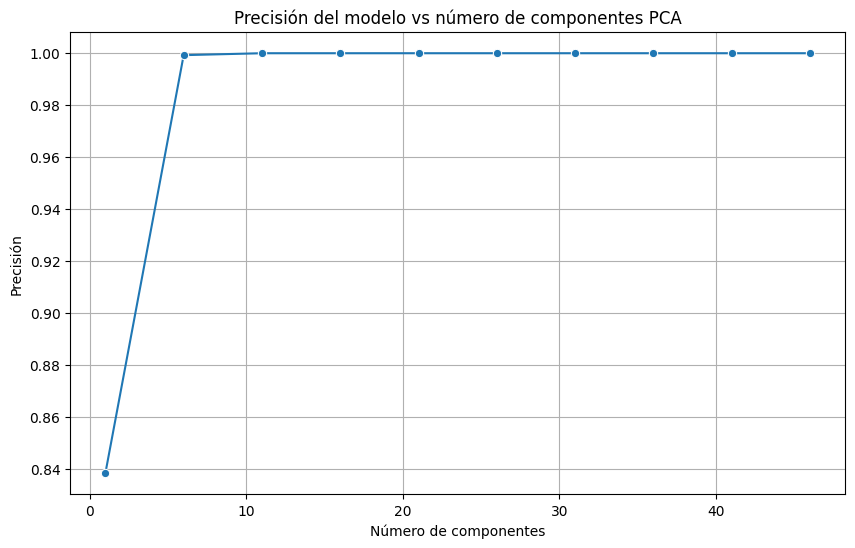

In [15]:
# Definir el rango de componentes PCA a probar
n_features = range(1, 50, 5)  # Probar 1, 6, 11, ..., 46 componentes
scores = []

for n in n_features:
    # 1. Aplicar PCA
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # 2. Entrenar Random Forest sobre los datos reducidos
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_pca, y_train)

    # 3. Predecir y calcular precisión
    y_pred = clf.predict(X_test_pca)
    score = accuracy_score(y_test, y_pred)

    # 4. Guardar el score
    scores.append(score)

# Mostrar resultados
plt.figure(figsize=(10, 6))
sns.lineplot(x=n_features, y=scores, marker="o")
plt.title("Precisión del modelo vs número de componentes PCA")
plt.xlabel("Número de componentes")
plt.ylabel("Precisión")
plt.grid(True)
plt.show()

Vale, estamos viendo que a partir de unas 10 features ya tenemos el score que queríamos y además hemos reducido las variables a un 10% de las que teníamos, incluso menos que las variables originales.

## Clustering

Viendo que el conjunto de datos es sencillito, podemos intentar hacer algo de clustering a ver qué información podemos obtener.

El primer paso va a ser importar la función de Kmeans de sklearn, y a partir de ahi, vamos a buscar el valor óptimo de clusters. Como hemos visto anteriormente, este valor lo obtenemos, por ejemplo, del codo de la gráfica que representa el total de las distancias de los puntos a los centros de los clusters asociados. Os dejo la página de la documentación de sklearn para que lo busquéis:

[K-Means on sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

Con esto solo hay que ahora generar los modelos de kmeans, evaluar y pintar la gráfica para los valores de ``k`` que establezcais.




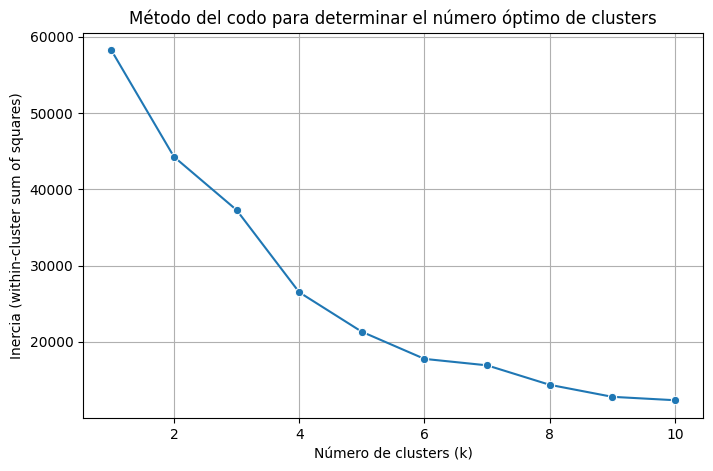

In [16]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_encoded)
scores = []
k_values = range(1, 11)  # Probar con k = 1 a 10

for k in k_values:
    # Definir y ajustar el modelo KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)

    # Guardar la inercia (suma de distancias a los centroides)
    scores.append(kmeans.inertia_)


# Graficar el método del codo
plt.figure(figsize=(8, 5))
sns.lineplot(x=k_values, y=scores, marker="o")
plt.title("Método del codo para determinar el número óptimo de clusters")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (within-cluster sum of squares)")
plt.grid(True)
plt.show()


Con el valor que hayáis obtenido de la gráfica, podéis obtener una buena aproximación de Kmeans y con ello podemos pasar a explorar cómo de bien han separado la información los distintos clusters. Para ello, se va a hacer un ``catplot``, seaborn os lo hará solito. Con esto lo que se pretende ver es la distribución de la varaible a predecir en función del cluster que haya determinado Kmeans.

In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)


df_clusters = pd.DataFrame({
    "cluster": clusters,
    "class": y.reset_index(drop=True)
})

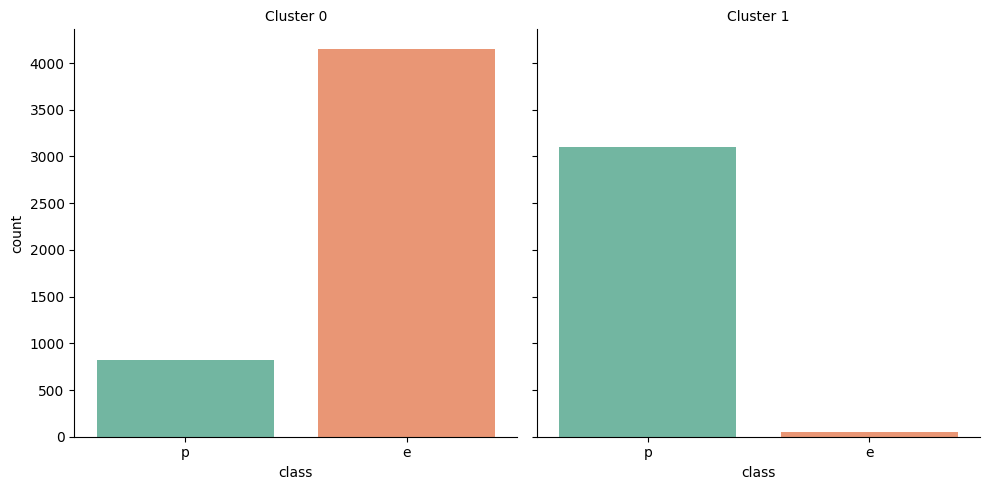

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Volver a generar el gráfico
ax = sns.catplot(
    col="cluster",
    x="class",
    hue="class",
    data=df_clusters,
    kind='count',
    col_wrap=2,
    palette="Set2"
)

ax.set_titles("Cluster {col_name}")
plt.show()

Vamos a ver qué tal queda esto pintado. Para ello, repetimos el scatterplot de antes pero usando como color el cluster asignado por kmeans.

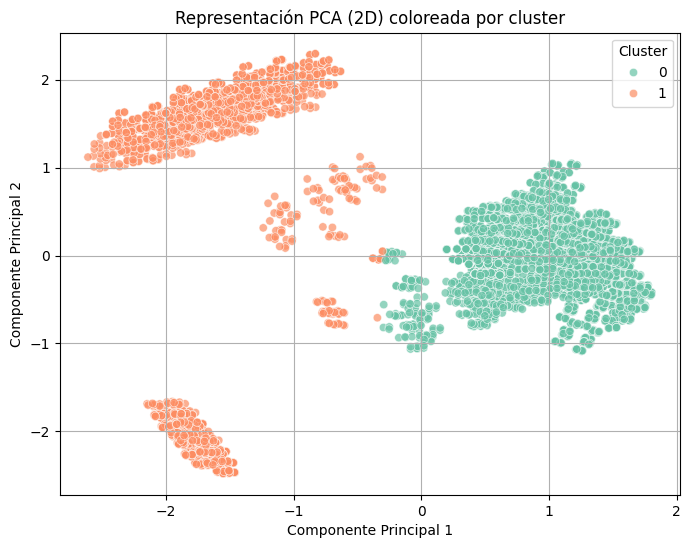

In [19]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Entrenar PCA para representar
pca = PCA(n_components=2)
X_pca_2D = pca.fit_transform(X_encoded)

# Usar un color por cada cluster.

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca_2D)

# Crear DataFrame para graficar
df_vis = pd.DataFrame(X_pca_2D, columns=["PC1", "PC2"])
df_vis["cluster"] = clusters

# Gráfico de dispersión con color por cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_vis, x="PC1", y="PC2", hue="cluster", palette="Set2", alpha=0.7)
plt.title("Representación PCA (2D) coloreada por cluster")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

¿Es bastante parecido no? No es tan bueno como el Random Forest, pero ha conseguido identificar bastante bien los distintos puntos del dataset sin utilizar las etiquetas. De hecho, el diagrama de factor que hemos visto antes muestra que solo un par de clusters son imprecisos. Si no hubieramos tenido etiquetas esta aproximacion nos hubiera ayudado mucho a clasificar los distintos tipos de hongos.

In [29]:
# Convertir etiquetas a numérico: edible → 0, poisonous → 1
y_numeric = y.map({'e': 0, 'p': 1}).values


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix # Import confusion_matrix

# --- 1. RANDOM FOREST: CÁLCULO DE MÉTRICAS CLÁSICAS ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Calcular la matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred, labels=['e', 'p'])
TP = cm_rf[1,1]
TN = cm_rf[0,0]
FP = cm_rf[0,1]
FN = cm_rf[1,0]

# Ahora puedes usar TP, TN, FP, FN para calcular otras métricas si lo necesitas
print("Matriz de Confusión:")
print(cm_rf)
print(f"Verdaderos Positivos (TP): {TP}")
print(f"Verdaderos Negativos (TN): {TN}")
print(f"Falsos Positivos (FP): {FP}")
print(f"Falsos Negativos (FN): {FN}")

Matriz de Confusión:
[[1378    0]
 [   0 1303]]
Verdaderos Positivos (TP): 1303
Verdaderos Negativos (TN): 1378
Falsos Positivos (FP): 0
Falsos Negativos (FN): 0


In [32]:
# Accuracy train y test
rf_accuracy_train = accuracy_score(y_train, rf.predict(X_train))
rf_accuracy_test = accuracy_score(y_test, y_pred)

# Precision, Recall, F1 (para clase 'p' = venenoso)
rf_precision = TP / (TP + FP) if (TP + FP) > 0 else 0
rf_recall = TP / (TP + FN) if (TP + FN) > 0 else 0
rf_f1 = 2 * (rf_precision * rf_recall) / (rf_precision + rf_recall) if (rf_precision + rf_recall) > 0 else 0

In [35]:
# --- 2. KMEANS: AJUSTE DE CLUSTERS PARA COMPARAR ---
cm = confusion_matrix(y_numeric, clusters)
if cm[0,0] + cm[1,1] >= cm[0,1] + cm[1,0]:
    TP_k = cm[1,1]
    TN_k = cm[0,0]
    FP_k = cm[0,1]
    FN_k = cm[1,0]
    clusters_adj = clusters
else:
    TP_k = cm[1,0]
    TN_k = cm[0,1]
    FP_k = cm[0,0]
    FN_k = cm[1,1]
    clusters_adj = 1 - clusters

kmeans_accuracy = (TP_k + TN_k) / (TP_k + TN_k + FP_k + FN_k)
kmeans_precision = TP_k / (TP_k + FP_k) if (TP_k + FP_k) > 0 else 0
kmeans_recall = TP_k / (TP_k + FN_k) if (TP_k + FN_k) > 0 else 0
kmeans_f1 = 2 * (kmeans_precision * kmeans_recall) / (kmeans_precision + kmeans_recall) if (kmeans_precision + kmeans_recall) > 0 else 0


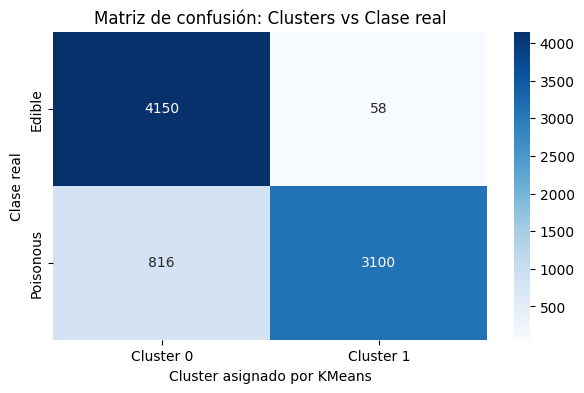

In [50]:
plt.figure(figsize=(7,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0','Cluster 1'], yticklabels=['Edible','Poisonous'])
plt.xlabel('Cluster asignado por KMeans')
plt.ylabel('Clase real')
plt.title('Matriz de confusión: Clusters vs Clase real')
plt.show()

In [48]:
# Import clustering evaluation metrics
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, fowlkes_mallows_score

# --- 2. KMEANS: AJUSTE DE CLUSTERS PARA COMPARAR ---
cm = confusion_matrix(y_numeric, clusters)
if cm[0,0] + cm[1,1] >= cm[0,1] + cm[1,0]:
    TP_k = cm[1,1]
    TN_k = cm[0,0]
    FP_k = cm[0,1]
    FN_k = cm[1,0]
    clusters_adj = clusters # No need to adjust if the mapping is already correct
else:
    # Adjust clusters if KMeans mapped the classes inversely
    TP_k = cm[1,0]
    TN_k = cm[0,1]
    FP_k = cm[0,0]
    FN_k = cm[1,1]
    clusters_adj = 1 - clusters

kmeans_accuracy = (TP_k + TN_k) / (TP_k + TN_k + FP_k + FN_k)
kmeans_precision = TP_k / (TP_k + FP_k) if (TP_k + FP_k) > 0 else 0
kmeans_recall = TP_k / (TP_k + FN_k) if (TP_k + FN_k) > 0 else 0
kmeans_f1 = 2 * (kmeans_precision * kmeans_recall) / (kmeans_precision + kmeans_recall) if (kmeans_precision + kmeans_recall) > 0 else 0

# Calculate clustering evaluation metrics
homogeneity = homogeneity_score(y_numeric, clusters)
completeness = completeness_score(y_numeric, clusters)
v_measure = v_measure_score(y_numeric, clusters)
ari = adjusted_rand_score(y_numeric, clusters)
fmi = fowlkes_mallows_score(y_numeric, clusters)


# --- 4. CUADRO COMPARATIVO DE MÉTRICAS ---
df_metrics = pd.DataFrame({
    'Modelo': ['Random Forest', 'KMeans'],
    'Accuracy (test)': [rf_accuracy_test, kmeans_accuracy],
    'Precision': [rf_precision, kmeans_precision],
    'Recall': [rf_recall, kmeans_recall],
    'F1-score': [rf_f1, kmeans_f1]
})
df_metrics_clustering = pd.DataFrame({
    'Métrica': ['Homogeneity', 'Completeness', 'V-Measure', 'ARI', 'FMI'],
    'KMeans': [homogeneity, completeness, v_measure, ari, fmi]
})

<Figure size 700x400 with 0 Axes>

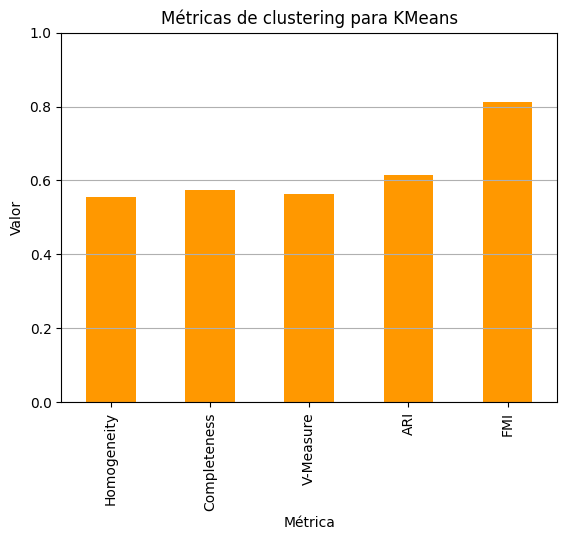

In [51]:
plt.figure(figsize=(7,4))
df_metrics_clustering.set_index('Métrica').plot(kind='bar', legend=False, color='#FF9800')
plt.title('Métricas de clustering para KMeans')
plt.ylabel('Valor')
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()

<Figure size 800x500 with 0 Axes>

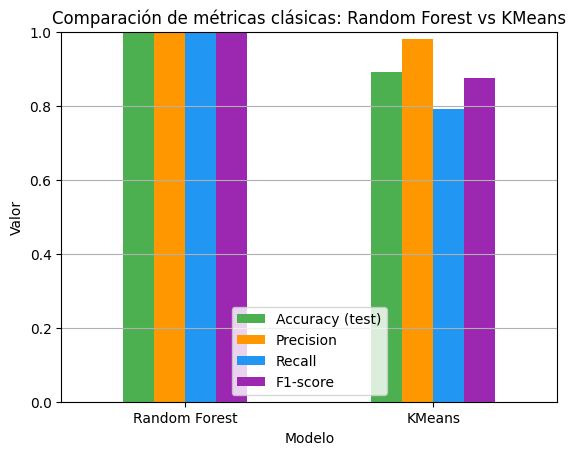

In [49]:
# --- 5. GRÁFICOS COMPARATIVOS ---
plt.figure(figsize=(8,5))
df_metrics.set_index('Modelo')[['Accuracy (test)','Precision','Recall','F1-score']].plot(kind='bar', ylim=(0,1), rot=0, color=['#4CAF50','#FF9800','#2196F3','#9C27B0'])
plt.title('Comparación de métricas clásicas: Random Forest vs KMeans')
plt.ylabel('Valor')
plt.grid(axis='y')
plt.show()


In [56]:
# --- 6. CUADRO RESUMEN DE LÍMITES Y EJEMPLOS ---
df_limites = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Homogeneity', 'Completeness', 'V-Measure', 'ARI', 'FMI'],
    'Mínimo': [0, 0, 0, 0, 0, 0, 0, -1, 0],
    'Máximo': [1, 1, 1, 1, 1, 1, 1, 1, 1],
    'Ejemplo (bueno)': [0.99, 0.98, 0.97, 0.97, 0.9, 0.9, 0.9, 0.9, 0.9],
    'Ejemplo (malo)': [0.5, 0.5, 0.5, 0.5, 0.2, 0.2, 0.2, 0, 0.2]
})

display(df_metrics)
print("\n--- MÉTRICAS DE CLUSTERING ---")
display(df_metrics_clustering)
print("\n--- LÍMITES Y EJEMPLOS ---")
display(df_limites)
print(f"\nAccuracy train: {rf_accuracy_train:.4f} | Accuracy test: {rf_accuracy_test:.4f} | Diferencia: {abs(rf_accuracy_train - rf_accuracy_test):.4f}")



,Modelo,Accuracy (test),Precision,Recall,F1-score
0,Random Forest,1.000000,1.000000,1.000000,1.000000
1,KMeans,0.892418,0.981634,0.791624,0.876449



--- MÉTRICAS DE CLUSTERING ---


,Métrica,KMeans
0,Homogeneity,0.554218
1,Completeness,0.574396
2,V-Measure,0.564127
3,ARI,0.615897
4,FMI,0.812921



--- LÍMITES Y EJEMPLOS ---


,Métrica,Mínimo,Máximo,Ejemplo (bueno),Ejemplo (malo)
0,Accuracy,0,1,0.99,0.5
1,Precision,0,1,0.98,0.5
2,Recall,0,1,0.97,0.5
3,F1-score,0,1,0.97,0.5
4,Homogeneity,0,1,0.90,0.2
5,Completeness,0,1,0.90,0.2
6,V-Measure,0,1,0.90,0.2
7,ARI,-1,1,0.90,0.0
8,FMI,0,1,0.90,0.2



Accuracy train: 1.0000 | Accuracy test: 1.0000 | Diferencia: 0.0000


from matplotlib import pyplot as plt
df_limites['Mínimo'].plot(kind='hist', bins=20, title='Mínimo')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_limites['Ejemplo (bueno)'].plot(kind='hist', bins=20, title='Ejemplo (bueno)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_limites['Ejemplo (malo)'].plot(kind='hist', bins=20, title='Ejemplo (malo)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_limites.plot(kind='scatter', x='Mínimo', y='Ejemplo (bueno)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_limites.plot(kind='scatter', x='Ejemplo (bueno)', y='Ejemplo (malo)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Máximo']
  ys = series['Mínimo']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_limites.sort_values('Máximo', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Máximo')
_ = plt.ylabel('Mínimo')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Máximo']
  ys = series['Ejemplo (bueno)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_limites.sort_values('Máximo', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Máximo')
_ = plt.ylabel('Ejemplo (bueno)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Máximo']
  ys = series['Ejemplo (malo)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_limites.sort_values('Máximo', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Máximo')
_ = plt.ylabel('Ejemplo (malo)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Máximo']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Máximo'}, axis=1)
              .sort_values('Máximo', ascending=True))
  xs = counted['Máximo']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_limites.sort_values('Máximo', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Máximo')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df_limites['Mínimo'].plot(kind='line', figsize=(8, 4), title='Mínimo')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_limites['Ejemplo (bueno)'].plot(kind='line', figsize=(8, 4), title='Ejemplo (bueno)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_limites['Ejemplo (malo)'].plot(kind='line', figsize=(8, 4), title='Ejemplo (malo)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['Accuracy (test)'].plot(kind='hist', bins=20, title='Accuracy (test)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['F1-score'].plot(kind='hist', bins=20, title='F1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_metrics.groupby('Modelo').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics.plot(kind='scatter', x='Accuracy (test)', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics.plot(kind='scatter', x='Recall', y='F1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['Accuracy (test)'].plot(kind='line', figsize=(8, 4), title='Accuracy (test)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['F1-score'].plot(kind='line', figsize=(8, 4), title='F1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_metrics['Modelo'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_metrics, x='Accuracy (test)', y='Modelo', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_metrics['Modelo'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_metrics, x='Precision', y='Modelo', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_metrics['Modelo'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_metrics, x='Recall', y='Modelo', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_metrics['Modelo'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_metrics, x='F1-score', y='Modelo', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### Resumen final
- Random Forest (supervisado) logra métricas casi perfectas porque aprende de las etiquetas.
- KMeans (no supervisado) puede acercarse mucho si los grupos naturales coinciden con las clases, pero nunca será tan perfecto.
- Las métricas de clustering te dicen si los clusters tienen sentido aunque no tengas etiquetas.
- Si accuracy train y test son similares, tu modelo está bien ajustado.
- Usa los gráficos y cuadros para comparar visualmente y decidir qué método y métrica es mejor para tu objetivo.